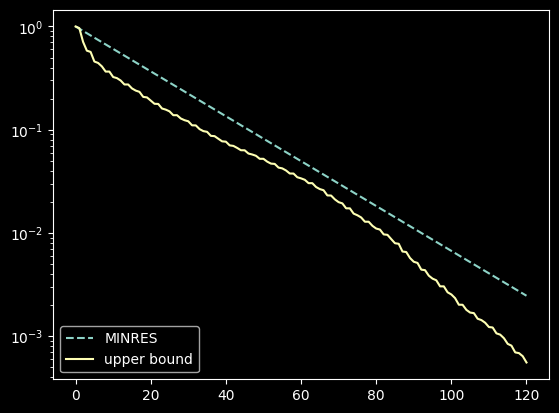

In [13]:
#8.6.2
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt

b = np.random.rand(202)
b_e = b / np.linalg.norm(b)
d1 = [-200 + 1.95 * k for k in range(101)]
d2 = [10 + 0.9 * k for k in range(101)]
d = np.hstack((d1, d2))
A = sp.diags(d)
hist = lambda x: resid.append(np.linalg.norm(b_e - A @ x))

m, M = min(-d[d < 0]), max(-d[d < 0])
kappa_minus = M / m
m, M = min(d[d > 0]), max(d[d > 0])
kappa_plus = M / m
S = np.sqrt(kappa_plus * kappa_minus)
rho = np.sqrt((S - 1) / (S + 1))

resid = [np.linalg.norm(b_e)]
xMR, flag = sp.linalg.minres(A, b_e, rtol=1e-12, maxiter=120, callback=hist)
upper = np.linalg.norm(b_e) * rho**np.arange(len(resid))
plt.semilogy(upper, "--")
plt.semilogy(resid)
plt.legend(["MINRES", "upper bound"], loc="lower left")
#plt.show()

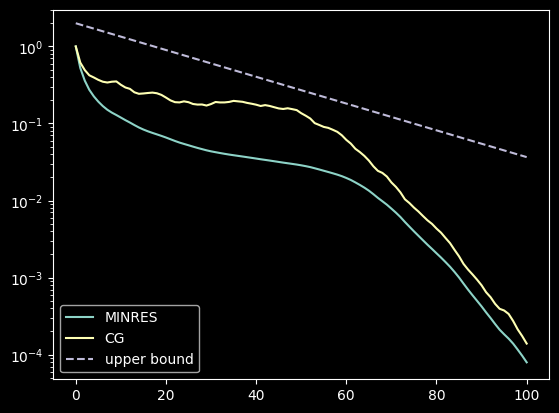

In [26]:
#8.6.3
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt

b = np.random.rand(501)
b_e = b / np.linalg.norm(b)
d = np.array([4 + k * (9996. / 500.) for k in range(501)])
A = sp.diags(d, format='lil')
hist = lambda x: resid.append(np.linalg.norm(b_e - A @ x))
resid = [np.linalg.norm(b_e)]

#画MINRES和它的上限
m, M = min(d), max(d)
kappa = M / m
S = np.sqrt(kappa)
rho = (S - 1) / (S + 1)
xMR, flag = sp.linalg.minres(A, b_e, rtol=1e-12, maxiter=100, callback=hist)
upper = 2 * rho**np.arange(len(resid))
plt.semilogy(resid)
#画CG
resid = [np.linalg.norm(b_e)]
xCG, flag = sp.linalg.cg(A, b_e, rtol=1e-12, maxiter=100, callback=hist)
plt.semilogy(resid)

plt.semilogy(upper, "--")
plt.ylim(top=3)
plt.legend(["MINRES", "CG" , "upper bound"], loc="lower left")

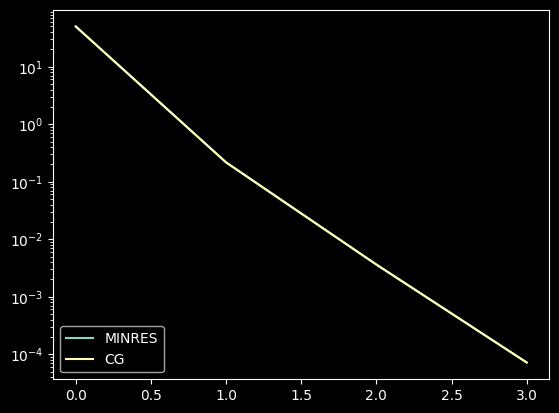

[-56.00758669+0.j]
[-63.99241331+0.j]


In [58]:
#8.6.6
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def poisson_2d(n):
    """
    构造二维 n*n 网格的离散拉普拉斯矩阵 A (大小 n^2 * n^2)
    这对应于 FNC.poisson(n)
    """
    # 1. 构造一维的算子 T (三对角矩阵)
    # 大小 n * n
    # 这里的 2 和 -1 是数学上的拓扑关系，物理参数(质量/张力)可以在外部乘上去
    data = [np.ones(n)*2, np.ones(n-1)*-1, np.ones(n-1)*-1]
    offsets = [0, 1, -1]
    T = sp.sparse.diags(data, offsets, shape=(n, n), format='csr')

    # 2. 利用 Kronecker Sum 扩展到二维
    # A = T ⊕ T
    # k = 1 (上下左右四个邻居)
    A = sp.sparse.kronsum(T, T, format='csr')

    return A

k = 8
n = 50
Ak = poisson_2d(n) - k**2 * sp.sparse.eye(n**2)
b = -1 * np.ones(n**2)
tol = 1e-5

redis = [np.linalg.norm(b)]
hist = lambda x: redis.append(np.linalg.norm(b - Ak @ x))
xMR, flag = sp.sparse.linalg.minres(Ak, b, rtol=tol, maxiter=100, callback=hist)
plt.semilogy(redis)

redis = [np.linalg.norm(b)]
xCG, flag = sp.sparse.linalg.cg(Ak, b, rtol=tol, maxiter=100, callback=hist)
plt.semilogy(redis)

plt.legend(["MINRES", "CG"], loc="lower left")
plt.show()

evmax, _ = sp.sparse.linalg.eigs(Ak, k=1, which='LR')
evmin, _ = sp.sparse.linalg.eigs(Ak, k=1, which='SR')
print(evmax)
print(evmin)

In [ ]:
import numpy as np

def minres(A, u, m):
    n = A.shape[0]
    Q = np.zeros([n, m + 1])
    H = np.zeros([m + 1, m])
    Q[:, 0] = u / np.linalg.norm(u)

    for i in range(m):
        v =  A @ Q[:, i]

        for j in range(max(0, i - 1), i + 1):
            H[j, i] = Q[:, j] @ v
            v -= H[j, i] * Q[:, j]

        H[i + 1, i] = np.linalg.norm(v)
        Q[:, i + 1] = v / H[i + 1, i]

        return Q, H

def cg(A, b, m, tol):
    x = np.zeros_like(b)
    r = b - A @ x #初始化残差
    p = r.copy() #初始化搜索方向

    for i in range(0, m):
        alpha = np.dot(r.T, r) / (p.T @ A @ p)

        x_new = x + np.dot(alpha, p)
        r_new = r -  alpha * (A @ p)
        #验证是否收敛
        if np.linalg.norm(r_new) < tol:
            break
        else:
            beta = np.dot(r_new.T, r_new) / np.dot(r.T, r) #计算方向修正系数
            p_new = r_new + beta * p

        p = p_new
        r = r_new
        x = x_new

    return x[-1]
